# Importing libraries

In [ ]:
# 'https://hilpisch.com/tr_eikon_eod_data.csv'
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
plt.style.use('seaborn-v0_8')
# print(plt.style.available)

In [ ]:
import numpy as np
import pandas as pd
import scipy.optimize as sco

# 1 - Vasicek stochastic interest rate model

Stochastic interest rate models can capture the random behavior of interest rates. The Vasicek interest rate model is the first stochastic interest rate model introduced in quantitative finance.

The equation governing the inrest rate in the Vasicek model is given by
\begin{align}
d r_t & = a (b-r_t) dt + \sigma dW_t\,,
\end{align}
where $r_t$ is interest rate at time $t$, $a$ is the speed of mean reversion (which specifies how fast the interest rate returns to the mean), $b$ is the long term average interest rate, $dt$ is usually $1/252$ (252 is the average number of trading days in US), $\sigma$ is the volatility of interest rates and $dW_t$ is the Brownian motion or Wiener process.

The randomness or unpredictability in the interest rates is modeled by the Brownian motion which is given by $dW_t = x_t \sqrt{dt}$, where $x_t$ is a random number generated from a normal distribution.

Note that the interest rates can fluctuate by economic news, market sentiment, policy change, and this behavior is captured by the Brownian motion contribution $dW_t$, which is also called the stochastic part.

Note that this model admits negative interest rates, so it can be a good fit for countries like Germany, Japan, etc. It is also a single factor model, which means that market risk $dW_t$ is the only part affecting the interest rate.

The parameters of the model are adjusted in such a way that the interest rate predicted by the Vasicek model closely aligns with the available data.

# 2 - Cox-Ingersoll-Ross stochastic interest rate model

Similar to the NS/NSS models, the Cox-Ingersoll-Ross (CIR) model is used to model the interest rate moments. The CIR model is also called one factor model, since it describes interest rate movement as driven by a sole function of market risk.

The equation governing the inrest rate in the CIR model is given by
\begin{align}
d r_t & = a (b-r_t) dt + \sigma \sqrt{r_t} dW_t\,,
\end{align}
where $r_t$ is the interst rate, $a$ is the speed of mean reversion (i.e., the speed that the interest rate reaches the mean), $b$ is the mean interest rate, $\sigma$ is the volatility and $dW_t$ is the Brownian motion (or Wiener process).

Let us analyze a few cases. Note that if $b > r_t $ there will be a positive movement, if $b < r_t$ there will be a negative movement. In addition, note that the Brownian motion term has vanishing mean.

The CIR model assumes mean reversion: interests rates tend to move towards long term equilibrium $b$. It also assumes that the parameters $\{a,b,\sigma\}$ are constant. However, note that these parameters might change in time due to economic and market conditions. It also assumes a continuous path for interest rates.

The Vasicek model does not have the term $\sqrt{r_t}$ multiplying the Brownian motion contribution $dW_t$ when compared to the CIR model, which means that the interest rates are always positive in the CIR model. This means that when modeling the US yield curve the CIR model will be preferred. On the other hand, when modeling the yield curve in Germany the Vasicek model will be the best choice.

Therefore, the CIR model will be the best fit when interest rates are always positive and the Vasicek model will be the best fit when interest rates are both positive and negative.


# 2 - Implementation

Data collected in https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2024.

## 2.1 - Vasicek model

We first download the US treasury data for different maturities.

In [ ]:
df_original = pd.read_csv('daily-trasuryrates_2023-2024_252.csv')
df0 = df_original.copy()

In [ ]:
df0 = df0[['Date', '3 Mo']]

In [ ]:
df1 = df0.copy()

In [ ]:
df1['3 Mo'] = df1['3 Mo']/100

In [ ]:
df1['Returns'] = df1['3 Mo'].pct_change()

In [ ]:
df1

,Date,3 Mo,Returns
0,06/01/2023,0.0550,NaN
1,06/02/2023,0.0550,0.000000
2,06/05/2023,0.0546,-0.007273
3,06/06/2023,0.0544,-0.003663
4,06/07/2023,0.0542,-0.003676
...,...,...,...
247,05/28/2024,0.0546,0.000000
248,05/29/2024,0.0546,0.000000
249,05/30/2024,0.0546,0.000000
250,05/31/2024,0.0546,0.000000


In [ ]:
df1.iloc[0, 2] = 5.5/5.52 - 1 # added missing treasury data

In [ ]:
df1['r(t + 1) - r(t)'] = 0

In [ ]:
df1['r(t + 1) - r(t)'] = df1['r(t + 1) - r(t)'].astype('float64')

In [ ]:
for i in range(len(df1)):
  if i < len(df1) - 1:
    df1.loc[i, 'r(t + 1) - r(t)'] = df1.loc[i + 1, '3 Mo'] - df1.loc[i, '3 Mo']
  else:
    df1.loc[len(df1) - 1, 'r(t + 1) - r(t)'] = 0.0 # added missing treasury data

In [ ]:
df1.tail()

,Date,3 Mo,Returns,r(t + 1) - r(t)
247,05/28/2024,0.0546,0.000000,0.0000
248,05/29/2024,0.0546,0.000000,0.0000
249,05/30/2024,0.0546,0.000000,0.0000
250,05/31/2024,0.0546,0.000000,0.0006
251,06/03/2024,0.0552,0.010989,0.0000


In [ ]:
def optimizer(dr, y):
  """
  Maximum likelihood estimator for the Vasicek model parameters.

  Parameters
  ==========
  dr: series
      change in actual interest rates
  y: series
     actual interest rates
  rets: series
        returns of actual interst rates

  Returns
  =======
  array with optimized parameters of the Vasicek model in the order [a, b, sigma]
  """

  def objective(x, delta_r, yield_gov):
    """
    Maximum likelihood function

    Parameters
    ==========
    x: list
       parameters of Vasicek model
    delta_r: series
             change in actual interest rates
    yield_gov: series
               actual interest rates

    Returns
    =======
    negative log likelihood
    """
    dt = 1 / len(yield_gov)
    log_likelihood = np.sum(
        -0.5 * np.log(2 * np.pi * x[2]**2)
        - ((delta_r - x[0] * (x[1] - yield_gov) * dt)**2 / (2 * x[2]**2))
    )
    return -log_likelihood  # Negative for minimization

  # Initial guess
  x = [0.10, 0.055, 0.00335]  # Speed, long-term mean rate, and volatility

  # Define bounds for the parameters
  bounds = [(1e-8, None),  # x[0] > 0 (speed)
            (None, None),  # x[1] unbounded (mean rate)
            (1e-8, None)]  # x[2] > 0 (volatility)

  # Perform the optimization
  result = sco.minimize(objective, x, args=(dr, y), method='L-BFGS-B', bounds=bounds)
  return result.x

In [ ]:
dr = df1['r(t + 1) - r(t)']
y = df1['3 Mo']
params_v = optimizer(dr, y)
print("[a, b, sigma] =", [params_v[0].round(4), params_v[1].round(4), params_v[2].round(4)])

[a, b, sigma] = [0.1014, 0.0613, 0.0002]


In [ ]:
a = params_v[0] # Speed of mean reversion
b = params_v[1] # Long-term mean
sigma = params_v[2] # volatility

In [ ]:
df1['sum_of_squares'] = (df1['r(t + 1) - r(t)'] - a * (b - df1['3 Mo']))**2

In [ ]:
df1.tail()

,Date,3 Mo,Returns,r(t + 1) - r(t),sum_of_squares
247,05/28/2024,0.0546,0.000000,0.0000,4.568542e-07
248,05/29/2024,0.0546,0.000000,0.0000,4.568542e-07
249,05/30/2024,0.0546,0.000000,0.0000,4.568542e-07
250,05/31/2024,0.0546,0.000000,0.0006,5.762318e-09
251,06/03/2024,0.0552,0.010989,0.0000,3.783148e-07


We can also see that the sum of squared errors is small.

In [ ]:
df1['sum_of_squares'].sum()

0.0001139116442417149

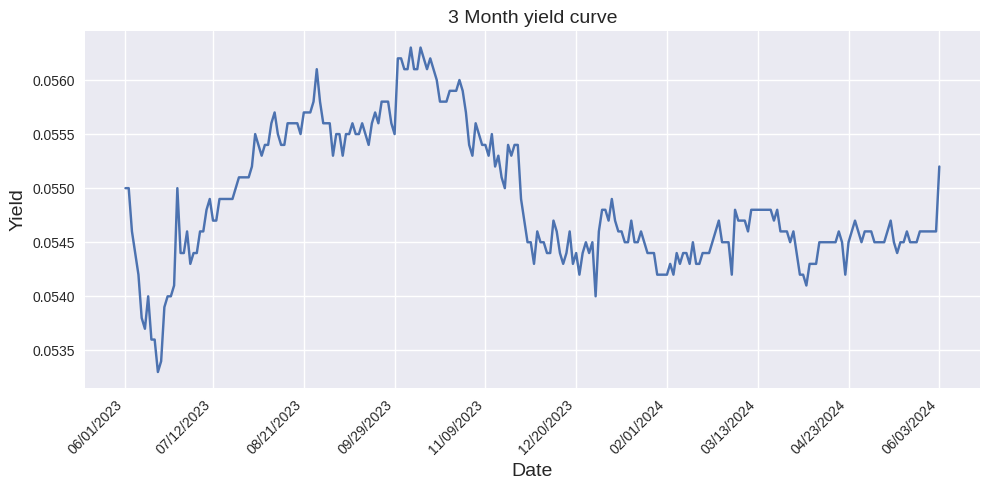

In [ ]:
dates = np.linspace(0, len(df1['Date']) - 1, 10, dtype=int)
selected_entries = df1['Date'].iloc[dates]
selected_dates = selected_entries.astype(str).tolist()
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df1['Date'], df1['3 Mo'])
ax.set_xticks(selected_dates)
ax.set_xticklabels(selected_dates, rotation=45, ha='right')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Yield', fontsize=14)
ax.set_title('3 Month yield curve', fontsize=14)
plt.tight_layout()
plt.show()

Let us now predict the 3 Month interest rate in the future using the Vasicek model.

In [ ]:
from numpy import random as rn

a = params_v[0] # Speed of mean reversion
b = params_v[1] # Long-term mean
sigma = params_v[2] # volatility
r0 = 0.0552 # Last day of data (spot rate)
T = 1 # Forecast horizon is one year
N = 252
dt = T/N # Length of each interval
M = int(5*1e4) # 50000 simulations
dz = rn.randn(M,N) # Matrix of random variables with mean zero and std = 1
r = r0*np.ones((M,N+1)) # Matrix of sample interest rates

In [ ]:
for i in range(0,N):
  r[:,i+1] = r[:,i] + a*(b-r[:,i])*dt + sigma*dz[:,i]*np.sqrt(dt)

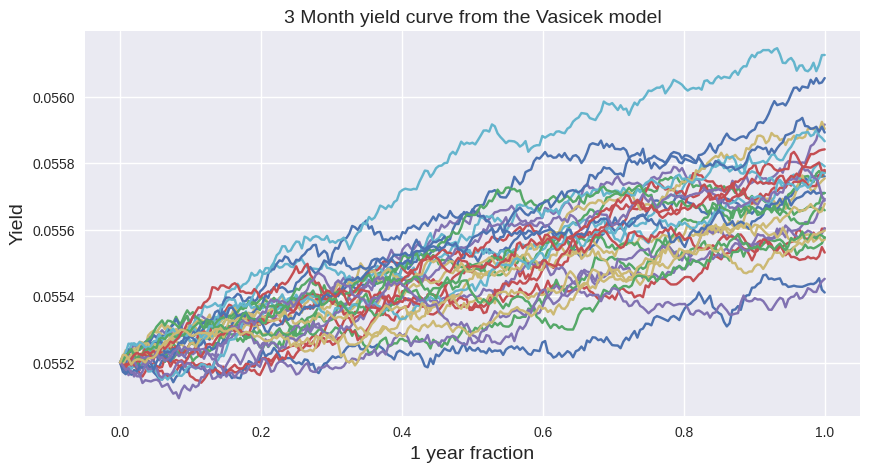

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
r_int = [ rn.randint(0,M) for j in range(1,30)] # 30 random integers between 0 and 49999
for runer in r_int:
    ax.plot(np.arange(0, T+dt, dt), r[runer])
ax.set_xlabel('1 year fraction', fontsize=14)
ax.set_ylabel('Yield', fontsize=14)
ax.set_title('3 Month yield curve from the Vasicek model', fontsize=14);

Let us now estimate the 3 Month yield half a year ahead.

In [ ]:
r[:,-125]

array([0.05540036, 0.05530373, 0.05525943, ..., 0.05539839, 0.05579788,
       0.05546866])

In [ ]:
V = r[:,-125]
print("The expected value for the interest rate at the end of 2024 is:","{:.3%}".format(np.mean(V)))
print("The standard error of sample mean is:", "{:.4%}".format(np.std(V)/np.sqrt(M)))

The expected value for the interest rate at the end of 2024 is: 5.551%
The standard error of sample mean is: 0.0001%


## 2.2 CIR model

The parameters $\{a, b, \sigma\}$ are the same as in the Vasicek model, so that we repeat the steps regarding the Monte Carlo simulation.

In [ ]:
a = params_v[0] # Speed of mean reversion
b = params_v[1] # Long-term mean
sigma = params_v[2] # volatility
r0 = 0.0552 # Last day of data (spot rate)
T = 1 # Forecast horizon is one year
N = 252
dt = T/N # Length of each interval
M = int(5*1e4) # 50000 simulations
dz = rn.randn(M,N) # Matrix of random variables with mean zero and std = 1
r = r0*np.ones((M,N+1)) # Matrix of sample interest rates

In [ ]:
for i in range(0,N):
  r[:,i+1] = r[:,i] + a*(b-r[:,i])*dt + sigma*np.sqrt(r[:,i])*dz[:,i]*np.sqrt(dt)

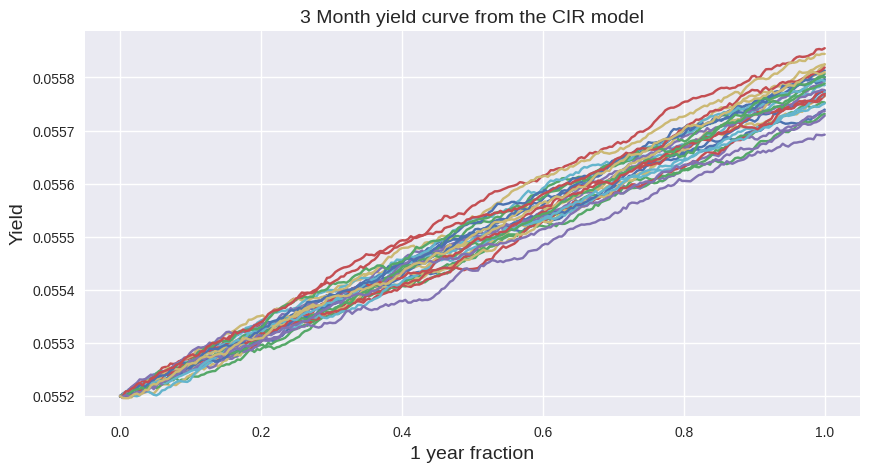

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
r_int = [ rn.randint(0,M) for j in range(1,30)] # 30 random integers between 0 and 49999
for runer in r_int:
    ax.plot(np.arange(0, T+dt, dt), r[runer])
ax.set_xlabel('1 year fraction', fontsize=14)
ax.set_ylabel('Yield', fontsize=14)
ax.set_title('3 Month yield curve from the CIR model', fontsize=14);

In [ ]:
V1 = (r[:,-1])
print("The expected value for the interest rate from the CIR model is:","{:.3%}".format(np.mean(V1)))
print("The standard error of sample mean is:", "{:.4%}".format(np.std(V1)/np.sqrt(M)))

The expected value for the interest rate from the CIR model is: 5.579%
The standard error of sample mean is: 0.0000%
